# Create new captions on unseen images

* Load model
* Load tokenizer and anything necessary for GloVe embeddings
* Load image and process it
* Get caption
* Use OpenCV to create a visual result

In [1]:
import pickle
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load model

In [2]:
model = tf.keras.models.load_model('./models/final_model.h5')

## Prepare Embeddings

In [3]:
# Tokenizer
tokenizer = pickle.load(open('./saved_data/tokenizer.pkl', 'rb'))

# Maxlength
maxlength = 37

## Load and Process Image

In [4]:
def extract_features(file):
    print('Extracting features...')

    # Load model
    model = VGG16()
    # Re-structure the model (we remove the last layer from the model because we don't need to classify the photos)
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # Load image from file
    image = load_img(file, target_size=(224, 224))
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    # Reshape image for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare image for the VGG model
    image = preprocess_input(image)
    # Extract features
    features = model.predict(image, verbose=0)

    print('Done')
    return features

In [5]:
image = 'example.jpg'
photo = extract_features(image)

Extracting features...
Done


## Get Caption

In [6]:
# Function that given an integer returns the corresponding word based on the tokenization
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word

    return None

In [7]:
def generate_description(model, tokenizer, photo, maxlength):
    # Word that starts the sequence
    in_text = 'STARTSEQ'
    # Iterate over the sequence
    for i in range(maxlength):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=maxlength)
        # Predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # Get the integer with the biggest probability
        yhat = np.argmax(yhat)
        # Get the word corresponding to the integer the model returned
        word = word_for_id(yhat, tokenizer)
        # Stop if no valid word was predicted
        if word is None:
            break
        # Append the predicted word as input for the next word
        in_text += ' ' + word
        # Stop if we predicted the end of the sequence
        if word.upper() == 'ENDSEQ':
            break

    return in_text

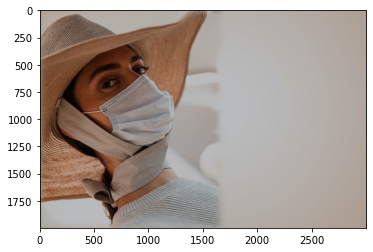


a man in a red shirt is standing on a bench with a dog in the background


In [8]:
description = generate_description(model, tokenizer, photo, maxlength)

description = ' '.join(description.split()[1:-1])

# Show image with description
image = plt.imread('example.jpg', 1)
plt.imshow(image)
plt.show()
print('')
print(description)

### Predict image from dataset

Extracting features...
Done


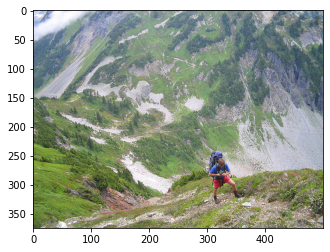


a man in a red shirt is standing on a rock overlooking a large waterfall


In [9]:
img_dataset = './Flicker8k_Dataset/58363928_6f7074608c.jpg'
img_dataset = extract_features(img_dataset)
description_dataset = generate_description(model, tokenizer, img_dataset, maxlength)

description_dataset = ' '.join(description_dataset.split()[1:-1])

# Show image with description
img_dataset = plt.imread(os.path.join('Flicker8k_Dataset', '58363928_6f7074608c.jpg'))
plt.imshow(img_dataset)
plt.show()
print('')
print(description_dataset)

## Use OpenCV to display the result visually

In [10]:
# READ IMAGE
img = cv2.imread('example.jpg', 1)

# RESIZE IMAGE
width_original = int(img.shape[1] * 0.4)
height_original = int(img.shape[0] * 0.4)

img = cv2.resize(img, (width_original, height_original), interpolation = cv2.INTER_AREA)


# DRAW BLACK BACKGROUND RECTANGLE
# Set position and dimensions of the rectangle
height, width, channels = img.shape
x,y,w,h = 0, (height - 50), width, 50

cv2.rectangle(img, (x, y), (x + w, y + h), (0,0,0), -1)

# ADD TEXT
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, description, (x + int(w/10), y + int(h/1.8)), font, fontScale=0.8, color=(255,255,255), thickness=2)

# DISPLAY IMAGE
cv2.imshow("Auto Captioning Image", img)

if cv2.waitKey(1):
    cv2.destroyAllWindows()